In [2]:
import requests
import os
import time
import pandas as pd
import numpy as np
import argparse
from math import sin, cos, asin, sqrt
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats
import networkx as nx
import osmnx as ox
from libpysal import weights
from pyogrio import read_dataframe
from matplotlib.pylab import cm
from matplotlib.colors import rgb2hex
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from geo_northarrow import add_north_arrow
import matplotlib.font_manager as fm
from matplotlib_scalebar.scalebar import ScaleBar

import warnings
warnings.filterwarnings("ignore")


ModuleNotFoundError: No module named 'osmnx'

In [55]:
Pth_hg_blk      = r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/gis_data/census/Houston-galveston.shp"
#Geodata = gpd.read_file(fp)
read_start      = time.process_time()
HG_ctcdata      = read_dataframe( Pth_hg_blk )
read_end        = time.process_time()
HG_ctcdata      = HG_ctcdata.to_crs({'init':'epsg:4326'})
HG_ctcdata.columns

/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Index(['NRI_ID', 'STATE', 'STATEABBRV', 'STATEFIPS', 'COUNTY', 'COUNTYTYPE',
       'COUNTYFIPS', 'STCOFIPS', 'TRACT', 'TRACTFIPS',
       ...
       'WNTW_ALRP', 'WNTW_ALRA', 'WNTW_ALR_N', 'WNTW_RISKV', 'WNTW_RISKS',
       'WNTW_RISKR', 'NRI_VER', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=469)

<Axes: >

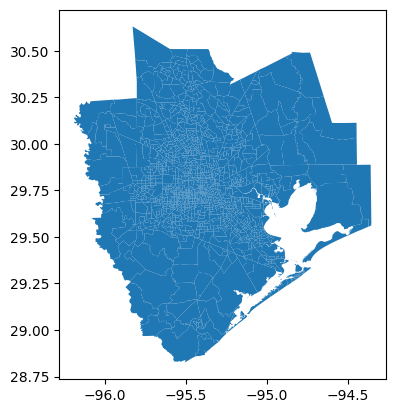

In [52]:
HG_ctcdata.plot()


In [56]:
print( HG_ctcdata.head() )
HG_ctcdata.TRACTFIPS = HG_ctcdata.TRACTFIPS.astype('double')
print( HG_ctcdata.TRACTFIPS.loc[2] )

         NRI_ID  STATE STATEABBRV STATEFIPS    COUNTY COUNTYTYPE COUNTYFIPS  \
0  T48039660100  Texas         TX        48  Brazoria     County        039   
1  T48039660200  Texas         TX        48  Brazoria     County        039   
2  T48039660301  Texas         TX        48  Brazoria     County        039   
3  T48039660302  Texas         TX        48  Brazoria     County        039   
4  T48039660303  Texas         TX        48  Brazoria     County        039   

  STCOFIPS   TRACT    TRACTFIPS  ...     WNTW_ALRP  WNTW_ALRA  WNTW_ALR_N  \
0    48039  660100  48039660100  ...  1.043800e-07   0.000013   73.530310   
1    48039  660200  48039660200  ...  1.043800e-07   0.000013   73.453977   
2    48039  660301  48039660301  ...  1.043800e-07   0.000013   73.517392   
3    48039  660302  48039660302  ...  1.043800e-07   0.000013   73.071142   
4    48039  660303  48039660303  ...  1.043800e-07   0.000013   73.310708   

    WNTW_RISKV  WNTW_RISKS           WNTW_RISKR     NRI_VER   

In [57]:
HG_ctcdata.bounds.max()
nodelist = HG_ctcdata.TRACTFIPS.tolist()

In [58]:

geo_nodes = pd.read_csv( r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/census_nodes_loc.csv" ) 
edge_data = pd.read_csv( r"/Users/yuhan/Desktop/Gradient_Boost_code/inputs/travel/census_edges.csv" ) 

print( geo_nodes.head() ) 
print( edge_data.head() )


         geoid        lng        lat
0  48201322100 -95.210421  29.690043
1  48201980000 -95.277263  29.646153
2  48201314300 -95.417726  29.683784
3  48201313100 -95.389865  29.710823
4  48201412200 -95.411071  29.706935
        source       target  popflow  visitflow
0  48201322100  48201980000    209.0          8
1  48201322100  48201314300    104.0          4
2  48201322100  48201313100    104.0          4
3  48201322100  48201412200    235.0          9
4  48201322100  48201343700    209.0          8


In [59]:
edge_data.popflow[ edge_data.popflow > 200 ].shape

(42227,)

In [60]:
#centroids = np.column_stack(( HG_blkdata.centroid.x, HG_blkdata.centroid.y ))
pos = {}
lon_list = []
lat_list = []
for idx, rowi in geo_nodes.iterrows():
    lngi = rowi['lng']
    lati = rowi['lat']
    geoi = rowi['geoid']
    if geoi in nodelist and lngi > -96.208 and lngi < -94.339 and lati < 30.547:
        pos[ geoi ] = (lngi, lati)
        lon_list.append( lngi )
        lat_list.append( lati )


In [61]:
G = nx.Graph()
G.add_nodes_from( pos.keys() )
nx.set_node_attributes( G, 'coord', pos.values() )

for idx, rowi in edge_data.iterrows():
    origid = rowi['source']
    destid = rowi['target']
    weight = rowi['popflow']
    if origid != destid and origid in pos and destid in pos:
        G.add_edge(origid, destid, weight = weight)

centroids = np.column_stack(( lon_list, lat_list ))

#elarge  = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 1000]
#emedium = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 200]
#esmall  = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 200]

edge_color_map = []
#cmap0 = cm.get_cmap('BuPu', 4)
cmap0 = ["#FFE094", "#4d5174", "#313866"]
edges_list = []
edgesize = []
for (u, v, d) in G.edges(data=True):
    edges_list.append((u, v))
    if d["weight"] <= 300:
        edgesize.append(0.0)
        #edge_color_map.append( rgb2hex(cmap0(1)[:3]) )
        edge_color_map.append( cmap0[0] )
    elif d["weight"] > 300 and d["weight"] < 800:
        edgesize.append(0.3)
        #edge_color_map.append( rgb2hex(cmap0(2)[:3]) )
        edge_color_map.append( cmap0[1] )
    else:
        edgesize.append(0.6)
        #edge_color_map.append( rgb2hex(cmap0(3)[:3]) )
        edge_color_map.append( cmap0[2] )



48201432701.0


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_62808/1969734850.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('GnBu', 4)


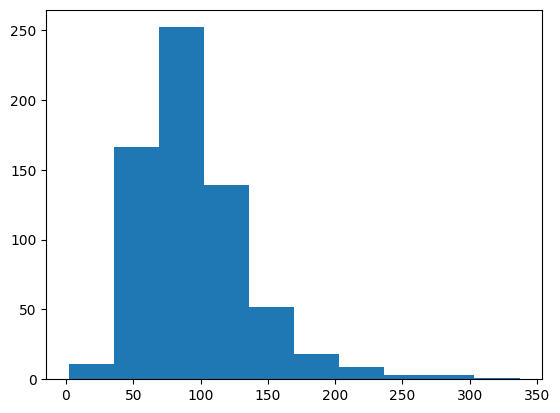

In [62]:

#queen = weights.Queen.from_dataframe( HG_blkdata )
print( origid )
degreex = nx.degree(G)

degrees = [ val for (node, val) in G.degree()  ]
plt.hist( degrees )

color_map = []
size_map = []
cmap = cm.get_cmap('GnBu', 4)
cmap = ["#756477" , "#d5003a", "#FFEB28"]
for node, val in G.degree():
    if val > 150:
        size_map.append( 20 )
        #color_map.append( rgb2hex(cmap(3)[:3]) )
        color_map.append( cmap[2] )
    elif val < 150 and val > 50:
        size_map.append( 8 )
        #color_map.append( rgb2hex(cmap(2)[:3]) )
        color_map.append( cmap[1] )
    else: 
        size_map.append( 0 )
        #color_map.append( rgb2hex(cmap(1)[:3]) )
        color_map.append( cmap[0] )

In [63]:
#graph = queen.to_networkx()
graph = G
positions = dict(zip( graph.nodes, centroids ))

print( graph.nodes )
print( centroids )


[48201322100.0, 48201980000.0, 48201343700.0, 48201252500.0, 48201233200.0, 48201350601.0, 48201341201.0, 48201341502.0, 48201321200.0, 48201233400.0, 48201521900.0, 48167723300.0, 48201210500.0, 48201342900.0, 48201433100.0, 48201324000.0, 48201334002.0, 48201310600.0, 48201412000.0, 48201342400.0, 48201342002.0, 48201533701.0, 48201342700.0, 48201232600.0, 48201323400.0, 48201334001.0, 48201421101.0, 48201340900.0, 48201342100.0, 48201254100.0, 48201530600.0, 48201450200.0, 48201411700.0, 48201321500.0, 48201310900.0, 48201222401.0, 48201323100.0, 48201322000.0, 48201342200.0, 48201552101.0, 48201323300.0, 48201323900.0, 48201210600.0, 48201321700.0, 48201323802.0, 48201320500.0, 48201311100.0, 48201340400.0, 48201311400.0, 48201342300.0, 48201321900.0, 48201323000.0, 48201323500.0, 48201323701.0, 48201343200.0, 48201320602.0, 48201331200.0, 48201322900.0, 48201231300.0, 48201322800.0, 48201334003.0, 48201323801.0, 48201311300.0, 48201333100.0, 48201321600.0, 48201323200.0, 482013226

In [12]:
#color_map
cmap


['#756477', '#d5003a', '#FFEB28']

In [13]:
HG_ctcdata.crs


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [48]:
color_theme = [ (232/255, 17/255, 15/ 255), 
               (251/255, 199/255, 35/ 255), 
               (27/255, 106/255, 165/ 255) ]
df.plot(color = color_theme)

NameError: name 'df' is not defined

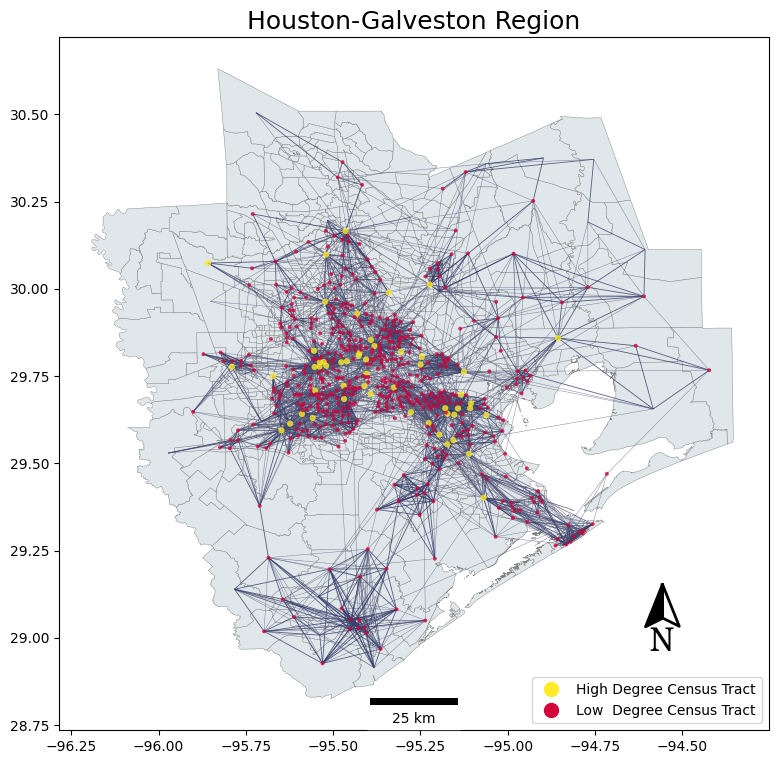

In [65]:
fig, ax = plt.subplots( 1, 1,  figsize=(12, 9) )

HG_ctcdata.plot(ax = ax, linewidth= 0.3, 
                     edgecolor="grey", 
                     facecolor="#DFE7EA")
#ax.axis([ -12, 45, 33, 66 ])
#ax.axis( "off" )
#nx.draw( graph, positions, ax = ax, 
#         node_size = 1, node_color="r" )
nx.draw_networkx_nodes(G, pos, node_size = size_map, 
                       node_color= color_map, ax = ax,
                       alpha = 0.8, linewidths = 0)

#nx.draw_networkx_nodes(G, pos_small, nodelist = smallnodes,
#                       node_size = 0.5, node_color="r")

# edges
nx.draw_networkx_edges(G, pos, edgelist= edges_list,  
                       width = edgesize, ax = ax,
                       edge_color= edge_color_map,
                       alpha = 0.8 )
#nx.draw_networkx_edges(G, pos, edgelist=emedium, width  = 0.3, edge_color="b")
#nx.draw_networkx_edges(G, pos, edgelist=esmall,  width  = 0.0, 
#                       alpha=0.5, edge_color="b", style="dashed")

x, y, arrow_length = 0.85, 0.15, 0.12
add_north_arrow(ax, scale   = .55,    xlim_pos    = x, ylim_pos = y, 
                color       = '#000', text_scaler = 4, text_yT  = -1.5)

ax.add_artist(  ScaleBar( 100, dimension="si-length", 
                units="km", location="lower center", 
                length_fraction = 0.2) )


#ctx.add_basemap(ax)
ax.set_axis_on()
#edge_labels = nx.get_edge_attributes(G, "weights")
#nx.draw_networkx_edge_labels(G, pos, edge_labels)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


legend_elements = [Line2D([0], [0], marker='o', color='#FFEB28', label='High Degree Census Tract', lw=0,
                          markerfacecolor='#FFEB28', markersize=10),
                   Line2D([0], [0], marker='o', color='#d5003a', label='Low  Degree Census Tract', lw=0,
                          markerfacecolor='#d5003a', markersize=10)]
ax.set_title('Houston-Galveston Region', fontsize= 18)

ax = plt.gca()
ax.legend(handles=legend_elements, loc='lower right')
fig.savefig('/Users/yuhan/Desktop/Writings/JCIT_00567_revision/fig_revision/NetworkFlows.png', 
            format='png', dpi=300, bbox_inches='tight')
plt.show() 


# Plot Transportation Network


In [2]:
import os 
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from pyogrio import read_dataframe
import time
import glob 
import plotly.graph_objects as go
import pandas as pd
import networkx as nx
import osmnx as ox


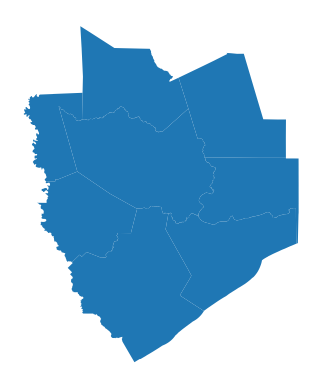

In [3]:
places = ox.geocode_to_gdf(['Brazoria, Texas', 'Chambers, Texas', 'Fort Bend, Texas' ,
'Galveston, Texas', 'Harris, Texas', 'Liberty, Texas', 'Montgomery, Texas', 'Waller, Texas'])
places = ox.project_gdf(places)
ax = places.plot()
_ = ax.axis('off')


In [30]:
places = places.to_crs(4326)
places.total_bounds

array([-96.192284 ,  28.6922616, -94.353383 ,  30.6304191])

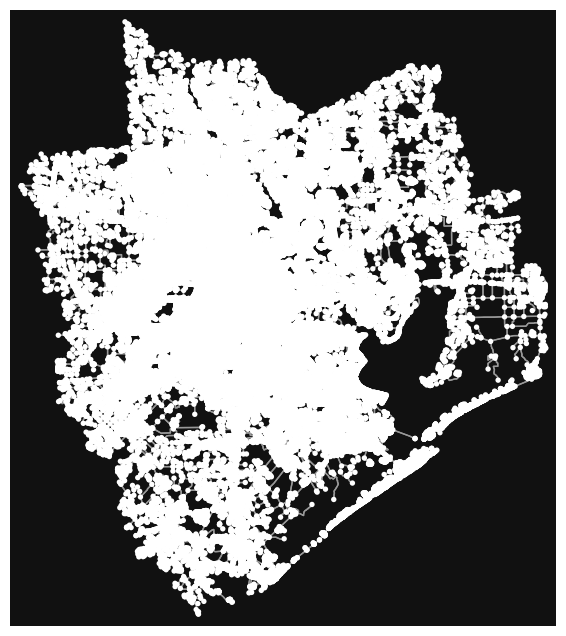

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
G_galveston = ox.graph_from_place(['Brazoria, Texas', 'Chambers, Texas', 'Fort Bend, Texas' , 
                                   'Galveston, Texas', 'Harris, Texas', 'Liberty, Texas', 
                                   'Montgomery, Texas', 'Waller, Texas'], network_type='drive')
ox.plot_graph( G_galveston )


In [ ]:
G_HG = ox.project_graph(G_galveston, to_crs='epsg:4326')


In [42]:
places.total_bounds


array([-96.192284 ,  28.6922616, -94.353383 ,  30.6304191])

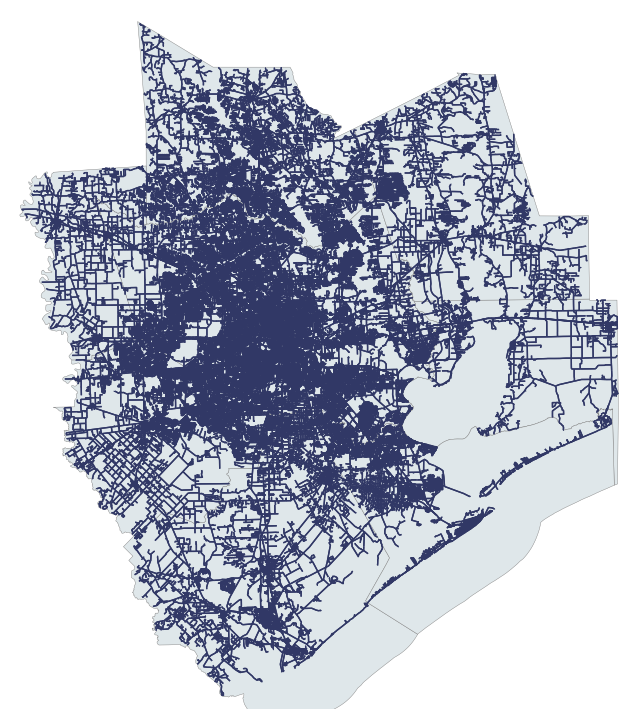

In [51]:
fig, ax = plt.subplots( figsize=(8, 10) )

places.plot(ax = ax, linewidth= 0.3, 
                     edgecolor="grey", 
                     facecolor="#DFE7EA")

ox.plot_graph( G_HG, figsize=(8, 8), bgcolor='#FEFEFF', node_color='w', 
               node_size= 0, node_alpha=None, node_edgecolor='none', 
               node_zorder=1, edge_color='#313866', edge_linewidth=1, 
               edge_alpha=None, show=True, close=False,  ax = ax
               #, save= True,
               #filepath= '/Users/yuhan/Desktop/Gradient_Boost_code/myimage3.png' , 
               #dpi=300  
               )

#edge_labels = nx.get_edge_attributes(G, "weights")
#nx.draw_networkx_edge_labels(G, pos, edge_labels)
ax.set_xlim(places.total_bounds[0],places.total_bounds[2])
ax.set_ylim(places.total_bounds[1],places.total_bounds[3])
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
fig.savefig('myimage3.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

'epsg:4326'